In [ ]:
import pandas as pd
import numpy as np
from functools import reduce

from sklearn.linear_model import LinearRegression
from scipy import ndimage
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = {}

koch_curve_url = 'https://raw.githubusercontent.com/ninavergara605/dimension_analysis/master/koch_curve.csv'
data['koch_curve']= pd.read_csv(koch_curve_url, nrows=160).squeeze().str.split(" ", expand=True).apply(pd.to_numeric, errors='ignore').values

data['rand_walk_rough'] = pd.read_csv('/content/gdrive/MyDrive/dimension_analysis/rough_random_walk.csv').values
data['rand_walk_smooth'] = pd.read_csv('/content/gdrive/MyDrive/dimension_analysis/smooth_random_walk.csv').values

### Helper Functions

In [ ]:
def plot_regression_line(ax, x, y,tag=None):
    X = x.reshape(-1,1) # Reshape x into nested structure
    
    # Initialize and fit a linear regression model
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X,y)

    # Get the regression line y-values and its slope
    y_pred = lr.predict(X) 
    slope = lr.coef_ 

    # Plot the regression line
    ax.plot(X,y_pred,c='r', label='Regression Line')
    # Create and set the subplot title
    dim_str = 'Dimension: ' + str(np.round(slope[0],3)) # Make dimension substring of title
    if tag:
      # If the data has a tag, prettyfie it and add dimension results
      title = ' '.join([*tag.title().split('_'), dim_str])
    else:
      # Otherwise, the title is the dimension substring
      title = dim_str
    ax.set_title(title)
    return slope # Return the slope for fun

In [ ]:
def create_image(data):
  # Create a line plot of the data
  fig, ax = plt.subplots()
  ax.plot(data[:,0], data[:,1], 'black')
  ax.set_axis_off()

  # Draw the plot on the canvas
  fig.canvas.draw ( )
  width, height = fig.canvas.get_width_height() # Grab canvas dimensions
  
  # Grab the bitwise representation of the canvas from buffer
  buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)  
  buf.shape = (height, width,3) # Reshape array into a 3D matrix with RGB layers

  # Convert the 3D grayscale image (2D- array)
  gray_image = color.rgb2gray(buf) 
  plt.close()
  return gray_image
  
def nd_distance_transform(image):
  '''
  Preforms an euclidian distance transform
  Each element is equal to its minimal distance to any object point
  '''
  transformed_image = ndimage.distance_transform_edt(image)
  return transformed_image


In [ ]:
def get_pixel_counts(dist_transform, E):
  max_pixel_count = max(transformed_img.shape)
  bins = pd.interval_range(start = 0, end = max_pixel_count , periods=max_pixel_count)
  counts = ndimage.histogram(transformed_img,0,max_pixel_count,max_pixel_count)
  
  areas = np.zeros(len(E))
  E_idxs = bins.get_indexer(E)
  for i, e_idx in enumerate(E_idxs):
    areas[i] = sum(counts[:e_idx+1])
  return areas

def calculate_graph_values(distance_transform):
  E = np.arange(1,70)
  areas = get_pixel_counts(distance_transform, E)

  X = np.log(1/E)
  y = np.log((1/E**2)* areas)
  return X,y 

### Minkowski-Bouligand Method

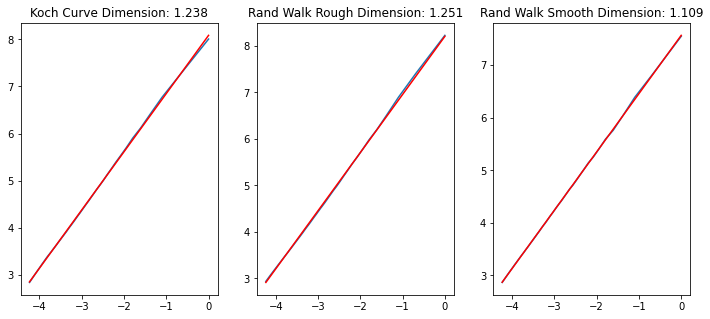

In [ ]:
 functions = [create_image, nd_distance_transform]
 fig, axs = plt.subplots(ncols=3, figsize=(12,5))
 for ax, (tag, points) in zip(axs, data.items()):
   transformed_img = reduce(lambda res, f: f(res), functions, points)
   X,y = calculate_graph_values(transformed_img)

   ax.plot(X,y)
   dimension = plot_regression_line(ax, X,y, tag=tag)

##Horizontal Segmentation Method

In [ ]:
def distance_transform_1d(arr):
  if not (0 in arr):
    # Return None if the row doesn't contain object points
    return
  
  # Compute the minimum distance array
  object_idxs = np.where(arr == 0)[0] # Grab the indexes of the objects
  transformed = np.zeros(arr.size)
  for i, val in enumerate(arr):
    if val == 1:
      # Current value is a background point
      distances = np.absolute(object_idxs - i) # Compute the distances to all objects
      transformed[i] = np.min(distances) # Set the transformed value to the smallest distance
    else:
      # The current value must be an object point
      transformed[i] = 0 # Set transformed value to 0
  return transformed

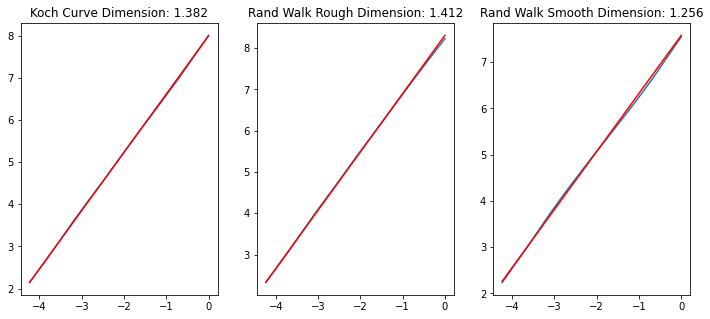

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
for ax, (tag, points) in zip(axes, data.items()):
  image = create_image(points) # Create a binarized representation of the function  
  # Apply a distance transform to each row of the image
  transformed_rows_raw = list(map(distance_transform_1d, image))

  # Filter out empty values and concatenate existing rows
  transformed_img = np.vstack(list(filter(lambda x: np.any(x), transformed_rows_raw)))

  X,y = calculate_graph_values(transformed_img)
  ax.plot(X,y)
  dimsension = plot_regression_line(ax, X,y, tag=tag)